<a href="https://colab.research.google.com/github/haoyuh3/ai-accelerator/blob/main/vgg_fer2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

## connect to google drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

train_dir = '/content/datasetr/train'
test_dir = '/content/datasetr/test'


In [3]:
import tensorflow as tf

# 检查是否有可用的GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available.")
    for gpu in gpus:
        print(f"Device: {gpu}")
else:
    print("No GPU available. Using CPU.")


GPU is available.
Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:

##dataset fer2013
import zipfile
from google.colab import drive


drive.mount('/content/drive')

zip_file_path = '/content/drive/MyDrive/haoyuh3/archive.zip'
destination_path = '/content/datasetr'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**VGG16** with data augumentation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

train_datagen = ImageDataGenerator(rescale = 1./255,
        validation_split = 0.2,
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

valid_dataset = valid_datagen.flow_from_directory(directory = train_dir,
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))

for layer in base_model.layers:
    layer.trainable=False
model.summary()

print(base_model.layers[18].trainable)

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 10,verbose = 1,callbacks=[lrd,mcp,es])


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 4096)              2101248   
                                                                 
 dropout_13 (Dropout)        (None, 4096)              0         
                                                                 
 dense_13 (Dense)            (None, 1024)              4195

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


359/359 [==============================] - 30s 79ms/step - loss: 1.8056 - accuracy: 0.8558 - precision: 0.3835 - recall: 0.0155 - auc: 0.6725 - f1_score: 0.0274 - val_loss: 1.7058 - val_accuracy: 0.8574 - val_precision: 0.6279 - val_recall: 0.0047 - val_auc: 0.7185 - val_f1_score: 0.0092 - lr: 0.0010
Epoch 2/10
359/359 [==============================] - 27s 76ms/step - loss: 1.7478 - accuracy: 0.8572 - precision: 0.5053 - recall: 0.0208 - auc: 0.6959 - f1_score: 0.0393 - val_loss: 1.7390 - val_accuracy: 0.8579 - val_precision: 0.8200 - val_recall: 0.0071 - val_auc: 0.7017 - val_f1_score: 0.0141 - lr: 0.0010
Epoch 3/10
359/359 [==============================] - 27s 76ms/step - loss: 1.7429 - accuracy: 0.8572 - precision: 0.5074 - recall: 0.0237 - auc: 0.6972 - f1_score: 0.0446 - val_loss: 1.7036 - val_accuracy: 0.8584 - val_precision: 0.6339 - val_recall: 0.0202 - val_auc: 0.7176 - val_f1_score: 0.0385 - lr: 0.0010
Epoch 4/10
359/359 [==============================] - 28s 77ms/step - lo

113/113 [==============================] - 2s 19ms/step - loss: 1.6602 - accuracy: 0.8598 - precision: 0.7610 - recall: 0.0266 - auc: 0.7460 - f1_score: 0.0504
[1.6601922512054443, 0.8597500324249268, 0.7609561681747437, 0.026609083637595177, 0.7459884881973267, 0.05043017491698265]


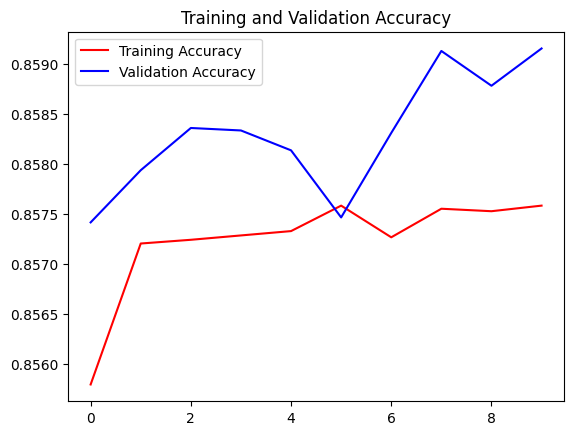

<Figure size 640x480 with 0 Axes>

In [ ]:
test_acc = model.evaluate(test_dataset)
print(test_acc)
acc= history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs,acc,'r',label='Training Accuracy')
plt.plot(epochs,val_acc,'b',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

VGG without data augumentation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

valid_dataset = valid_datagen.flow_from_directory(directory = train_dir,
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))

for layer in base_model.layers:
    layer.trainable=False
model.summary()

print(base_model.layers[18].trainable)

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 10,verbose = 1,callbacks=[lrd,mcp,es])


Found 28709 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 4096)              2101248   
                                                                 
 dropout_10 (Dropout)        (None, 4096)              0         
                                                                 
 dense_10 (Dense)            (None, 1024)              4195

113/113 [==============================] - 2s 20ms/step - loss: 1.6098 - accuracy: 0.8615 - precision: 0.7809 - recall: 0.0422 - auc: 0.7731 - f1_score: 0.0784
[1.6098048686981201, 0.8614814877510071, 0.780927836894989, 0.042212314903736115, 0.7731387615203857, 0.07839799672365189]


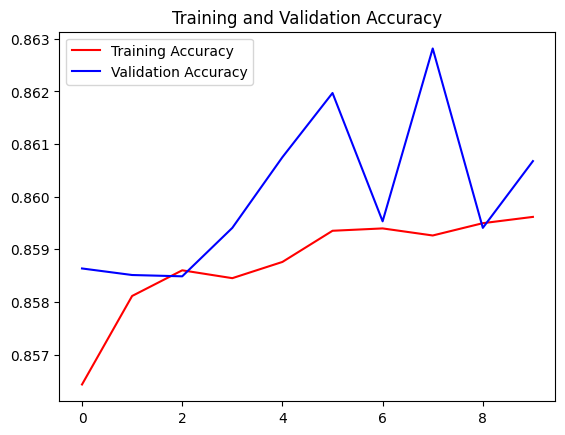

<Figure size 640x480 with 0 Axes>

In [ ]:
test_acc = model.evaluate(test_dataset)
print(test_acc)
acc= history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs,acc,'r',label='Training Accuracy')
plt.plot(epochs,val_acc,'b',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

resnet 50

In [ ]:
pip install opencv-python dlib


In [ ]:
pip install facenet-pytorch


In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

train_dir = '/content/datasetr/train'
test_dir = '/content/datasetr/test'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

valid_dataset = valid_datagen.flow_from_directory(directory = train_dir,
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

base_model = ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))


model.summary()

print(base_model.layers[18].trainable)

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 10,verbose = 1,callbacks=[lrd,mcp,es])


Found 28709 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_9 (Dropout)         (None, 8192)              0         
                                                                 
 dense_9 (Dense)             (None, 4096)              33558528  
                                                                 
 dropout_10 (Dropout)        (None, 4096)              0         
                                                            

113/113 [==============================] - 3s 26ms/step - loss: 1.3814 - accuracy: 0.8805 - precision: 0.6347 - recall: 0.3853 - auc: 0.8548 - f1_score: 0.4782
[1.3814117908477783, 0.8805078864097595, 0.6346948146820068, 0.38534411787986755, 0.8547511696815491, 0.47822821140289307]


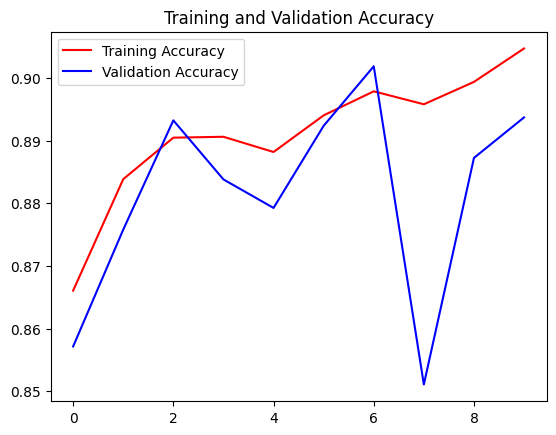

<Figure size 640x480 with 0 Axes>

In [12]:
test_acc = model.evaluate(test_dataset)
print(test_acc)
acc= history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs,acc,'r',label='Training Accuracy')
plt.plot(epochs,val_acc,'b',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [11]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import InceptionV3
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.optimizers import Adam
# import matplotlib.pyplot as plt
# from tensorflow.keras.layers import Dense, Flatten, Dropout

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import keras.backend as K
# import tensorflow as tf
# # Data generators with augmentation
# train_datagen = ImageDataGenerator(rescale = 1./255)
# valid_datagen = ImageDataGenerator(rescale = 1./255,
#                                   validation_split = 0.2)

# test_datagen  = ImageDataGenerator(rescale = 1./255
#                                   )

# train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
#                                                    target_size = (75,75),
#                                                    class_mode = 'categorical',
#                                                    subset = 'training',
#                                                    batch_size = 64)

# valid_dataset = valid_datagen.flow_from_directory(directory = train_dir,
#                                                   target_size = (75,75),
#                                                   class_mode = 'categorical',
#                                                   subset = 'validation',
#                                                   batch_size = 64)

# test_dataset = test_datagen.flow_from_directory(directory = test_dir,
#                                                   target_size = (75,75),
#                                                   class_mode = 'categorical',
#                                                   batch_size = 64)

# base_model = InceptionV3(input_shape=(75,75,3),include_top=False,weights="imagenet")

# model=Sequential()
# model.add(base_model)
# model.add(Flatten())
# model.add(Dropout(0.5))
# model.add(Dense(4096,activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1024,activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(7,activation='softmax'))

# for layer in base_model.layers:
#     layer.trainable=False
# model.summary()

# def f1_score(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val

# METRICS = [
#       tf.keras.metrics.BinaryAccuracy(name='accuracy'),
#       tf.keras.metrics.Precision(name='precision'),
#       tf.keras.metrics.Recall(name='recall'),
#       tf.keras.metrics.AUC(name='auc'),
#         f1_score,
# ]

# lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

# mcp = ModelCheckpoint('model.h5')

# es = EarlyStopping(verbose=1, patience=20)

# model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

# history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 10,verbose = 1,callbacks=[lrd,mcp,es])



113/113 [==============================] - 3s 24ms/step - loss: 1.5674 - accuracy: 0.8651 - precision: 0.7691 - recall: 0.0798 - auc: 0.7766 - f1_score: 0.1435
[1.5674011707305908, 0.8651235699653625, 0.7691274881362915, 0.07982724905014038, 0.7765926718711853, 0.14351414144039154]


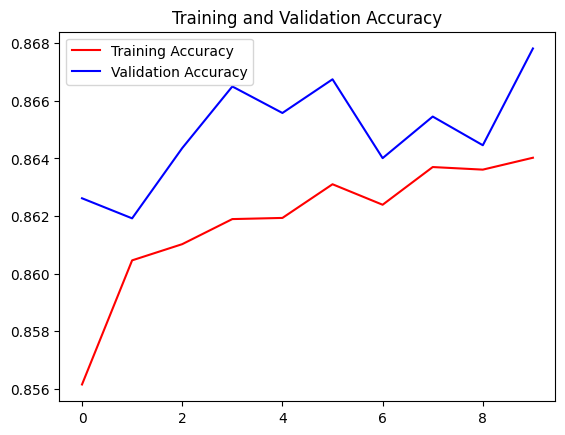

<Figure size 640x480 with 0 Axes>

In [9]:
# test_acc = model.evaluate(test_dataset)
# print(test_acc)
# acc= history.history['accuracy']
# val_acc=history.history['val_accuracy']
# loss=history.history['loss']
# val_loss=history.history['val_loss']

# epochs=range(len(acc))

# plt.plot(epochs,acc,'r',label='Training Accuracy')
# plt.plot(epochs,val_acc,'b',label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend(loc=0)
# plt.figure()

# plt.show()

**try to use different technique to improve performance**
1. attention
2. multi task/ multi modal

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Activation, multiply, concatenate, Input
from tensorflow.keras.applications import InceptionV3

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Dropout

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf

def spatial_attention_module(input_feature):
    kernel_size = 7

    avg_pool = tf.reduce_mean(input_feature, axis=3, keepdims=True)
    max_pool = tf.reduce_max(input_feature, axis=3, keepdims=True)
    concat = concatenate([avg_pool, max_pool], axis=3)
    attention = Conv2D(1, (kernel_size, kernel_size), padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    output = multiply([input_feature, attention])
    return output

# Data generators with augmentation
train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (75,75),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

valid_dataset = valid_datagen.flow_from_directory(directory = train_dir,
                                                  target_size = (75,75),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = (75,75),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

base_model = InceptionV3(input_shape=(75,75,3),include_top=False,weights="imagenet")





for layer in base_model.layers:
    layer.trainable = False

# 获取 'mixed7' 层的输出
x = base_model.get_layer('mixed7').output

# 可选：在这里添加空间注意力模块
x = spatial_attention_module(x)

# 在 'mixed7' 输出之上添加自定义层
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output_tensor = Dense(7, activation='softmax')(x)  # 假设有7个类别

model = Model(inputs=base_model.input, outputs=output_tensor)
model.summary()

print(base_model.layers[18].trainable)

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 10,verbose = 1,callbacks=[lrd,mcp,es])



Found 28709 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 conv2d_684 (Conv2D)         (None, 37, 37, 32)           864       ['input_14[0][0]']            
                                                                                                  
 batch_normalization_470 (B  (None, 37, 37, 32)           96        ['conv2d_684[0][0]']          
 atchNormalization)                                                                               
                                                                

113/113 [==============================] - 3s 25ms/step - loss: 1.2622 - accuracy: 0.8850 - precision: 0.7401 - recall: 0.3006 - auc: 0.8638 - f1_score: 0.4273
[1.2621556520462036, 0.8850057721138, 0.7400548458099365, 0.30064085125923157, 0.8637830018997192, 0.42730578780174255]


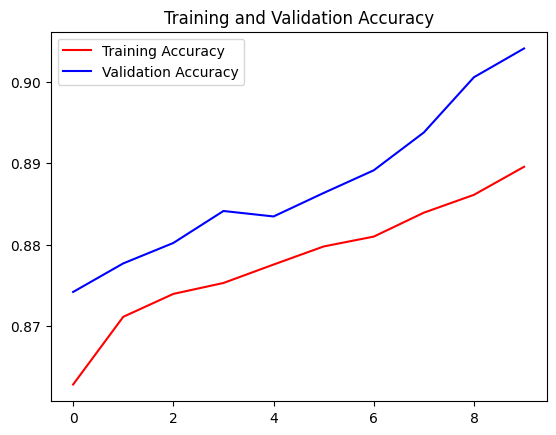

<Figure size 640x480 with 0 Axes>

In [ ]:
test_acc = model.evaluate(test_dataset)
print(test_acc)
acc= history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs,acc,'r',label='Training Accuracy')
plt.plot(epochs,val_acc,'b',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Activation, multiply, concatenate, Input
from tensorflow.keras.applications import InceptionV3

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Dropout

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Multiply, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
import pandas as pd

import tensorflow as tf

In [13]:
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Activation, multiply, concatenate, Input


from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Dropout

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Multiply, concatenate
from tensorflow.keras.models import Model
def InceptionV3_mine(
    include_top=True,
    input_shape=None,
    pooling=None,
    classes=7,
    classifier_activation="softmax",
):
    """Instantiates the Inception v3 architecture.

    Reference:
    - [Rethinking the Inception Architecture for Computer Vision](
        http://arxiv.org/abs/1512.00567) (CVPR 2016)

    This function returns a Keras image classification model,
    optionally loaded with weights pre-trained on ImageNet.

    For image classification use cases, see
    [this page for detailed examples](
      https://keras.io/api/applications/#usage-examples-for-image-classification-models).

    For transfer learning use cases, make sure to read the
    [guide to transfer learning & fine-tuning](
      https://keras.io/guides/transfer_learning/).

    Note: each Keras Application expects a specific kind of input preprocessing.
    For `InceptionV3`, call
    `keras.applications.inception_v3.preprocess_input` on your inputs
    before passing them to the model.
    `inception_v3.preprocess_input` will scale input pixels between -1 and 1.

    Args:
        include_top: Boolean, whether to include the fully-connected
            layer at the top, as the last layer of the network.
            Defaults to `True`.
        weights: One of `None` (random initialization),
            `imagenet` (pre-training on ImageNet),
            or the path to the weights file to be loaded.
            Defaults to `"imagenet"`.
        input_tensor: Optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model. `input_tensor` is useful for
            sharing inputs between multiple different networks.
            Defaults to `None`.
        input_shape: Optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(299, 299, 3)` (with `channels_last` data format)
            or `(3, 299, 299)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 75.
            E.g. `(150, 150, 3)` would be one valid value.
            `input_shape` will be ignored if the `input_tensor` is provided.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` (default) means that the output of the model will be
                the 4D tensor output of the last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is `True`, and
            if no `weights` argument is specified. Defaults to 1000.
        classifier_activation: A `str` or callable. The activation function
            to use on the "top" layer. Ignored unless `include_top=True`.
            Set `classifier_activation=None` to return the logits of the "top"
            layer. When loading pretrained weights, `classifier_activation`
            can only be `None` or `"softmax"`.

    Returns:
        A model instance.
    """

    channel_axis = 3
    img_input = layers.Input(shape=input_shape)

    x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding="valid")
    x = conv2d_bn(x, 32, 3, 3, padding="valid")
    x = conv2d_bn(x, 64, 3, 3)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv2d_bn(x, 80, 1, 1, padding="valid")
    x = conv2d_bn(x, 192, 3, 3, padding="valid")
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # mixed 0: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D(
        (3, 3), strides=(1, 1), padding="same"
    )(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name="mixed0",
    )

    # mixed 1: 35 x 35 x 288
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D(
        (3, 3), strides=(1, 1), padding="same"
    )(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name="mixed1",
    )

    # mixed 2: 35 x 35 x 288
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D(
        (3, 3), strides=(1, 1), padding="same"
    )(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name="mixed2",
    )

    # mixed 3: 17 x 17 x 768
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding="valid")

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(
        branch3x3dbl, 96, 3, 3, strides=(2, 2), padding="valid"
    )

    branch_pool = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate(
        [branch3x3, branch3x3dbl, branch_pool], axis=channel_axis, name="mixed3"
    )

    # mixed 4: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = layers.AveragePooling2D(
        (3, 3), strides=(1, 1), padding="same"
    )(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name="mixed4",
    )

    # mixed 5, 6: 17 x 17 x 768
    for i in range(2):
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = layers.AveragePooling2D(
            (3, 3), strides=(1, 1), padding="same"
        )(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch7x7, branch7x7dbl, branch_pool],
            axis=channel_axis,
            name="mixed" + str(5 + i),
        )

    # mixed 7: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 192, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = layers.AveragePooling2D(
        (3, 3), strides=(1, 1), padding="same"
    )(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name="mixed7",
    )

    # mixed 8: 8 x 8 x 1280
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3, strides=(2, 2), padding="valid")

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(
        branch7x7x3, 192, 3, 3, strides=(2, 2), padding="valid"
    )

    branch_pool = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate(
        [branch3x3, branch7x7x3, branch_pool], axis=channel_axis, name="mixed8"
    )

    # mixed 9: 8 x 8 x 2048
    for i in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = layers.concatenate(
            [branch3x3_1, branch3x3_2],
            axis=channel_axis,
            name="mixed9_" + str(i),
        )

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = layers.concatenate(
            [branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis
        )

        branch_pool = layers.AveragePooling2D(
            (3, 3), strides=(1, 1), padding="same"
        )(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch3x3, branch3x3dbl, branch_pool],
            axis=channel_axis,
            name="mixed" + str(9 + i),
        )

        if pooling == "avg":
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == "max":
            x = layers.GlobalMaxPooling2D()(x)


    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_tensor = Dense(classes, activation='softmax')(x)  # 假设有7个类别

    model = Model(inputs=img_input, outputs=output_tensor)
    model.summary()



    return model


def conv2d_bn(
    x, filters, num_row, num_col, padding="same", strides=(1, 1), name=None
):
    """Utility function to apply conv + BN.

    Args:
        x: input tensor.
        filters: filters in `Conv2D`.
        num_row: height of the convolution kernel.
        num_col: width of the convolution kernel.
        padding: padding mode in `Conv2D`.
        strides: strides in `Conv2D`.
        name: name of the ops; will become `name + '_conv'`
            for the convolution and `name + '_bn'` for the
            batch norm layer.

    Returns:
        Output tensor after applying `Conv2D` and `BatchNormalization`.
    """
    if name is not None:
        bn_name = name + "_bn"
        conv_name = name + "_conv"
    else:
        bn_name = None
        conv_name = None

    x = layers.Conv2D(
        filters,
        (num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=False,
        name=conv_name,
    )(x)
    x = layers.BatchNormalization(axis=3, scale=False, name=bn_name)(x)
    x = layers.Activation("relu", name=name)(x)
    return x

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (75,75),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

valid_dataset = valid_datagen.flow_from_directory(directory = train_dir,
                                                  target_size = (75,75),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = (75,75),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

base_model = InceptionV3_mine(input_shape=(75,75,3))

model=Sequential()
model.add(base_model)


model.summary()

print(base_model.layers[18].trainable)

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 10,verbose = 1,callbacks=[lrd,mcp,es])


Found 28709 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 conv2d_282 (Conv2D)         (None, 37, 37, 32)           864       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_282 (B  (None, 37, 37, 32)           96        ['conv2d_282[0][0]']          
 atchNormalization)                                                                               
                                                                  

In [ ]:
test_acc = model.evaluate(test_dataset)
print(test_acc)
acc= history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs,acc,'r',label='Training Accuracy')
plt.plot(epochs,val_acc,'b',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()